In [3]:
import pandas as pd
import numpy as np

In [4]:
# importing the dataset
df_train = pd.read_csv('/content/drive/MyDrive/emotion dataset/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('/content/drive/MyDrive/emotion dataset/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('/content/drive/MyDrive/emotion dataset/val.txt',header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

In [5]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
print(df_train.shape,df_test.shape,df_val.shape)

(16000, 2) (2000, 2) (2000, 2)


**EDA**

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBaackend.figure_format = 'retina'

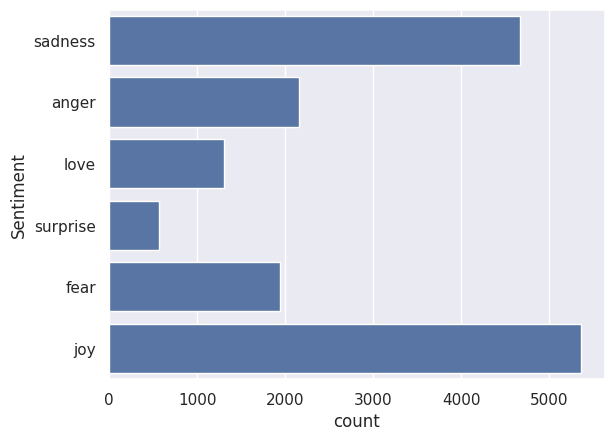

In [8]:
sns.countplot(df_train['Sentiment'])
plt.show()

In [9]:
print(df_train.columns)

Index(['Input', 'Sentiment'], dtype='object')


In [10]:
df_train['Length'] = df_train.Input.apply(lambda x:len(x))

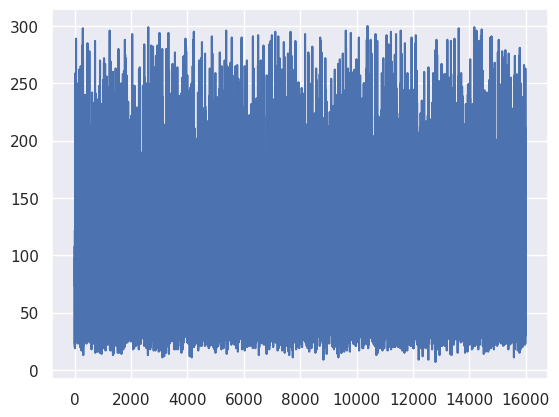

In [11]:
plt.plot(df_train.Length)
plt.show()

In [12]:
df_train.Length.max()

300

In [13]:
#using a text preprocessing library
!pip install text_hammer
import text_hammer as th

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.3
    Uninstalling beautifulsoup4-4.12.3:
      Successfully uninstalled beautifulsoup4-4.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.40 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [14]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
# df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
# here we can remove stop-words but in this case removing not, and ,can change the meaning of context

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 695 µs, sys: 0 ns, total: 695 µs
Wall time: 673 µs


In [15]:
df_cleaned_train = text_preprocessing(df_train,'Input')

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

In [16]:
df_cleaned_train.head()

,Input,Sentiment,Length
0,I do not feel humiliate,sadness,23
1,I can go from feel so hopeless to so damned ho...,sadness,108
2,I m grab a minute to post I feel greedy wrong,anger,48
3,I am ever feel nostalgic about the fireplace I...,love,92
4,I am feel grouchy,anger,20


In [17]:
df_cleaned_train['Sentiment']=df_cleaned_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_test['Sentiment']=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_val['Sentiment']=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [18]:
from keras.preprocessing.text import Tokenizer

In [19]:
num_words = 10000 # this means 10000 unique words can be taken
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([df_cleaned_train['Input'], df_test.Input], axis = 0)
tokenizer.fit_on_texts(df_total)

In [20]:
len(tokenizer.word_index)

13891

In [21]:
from keras.preprocessing.sequence import pad_sequences

X_train=tokenizer.texts_to_sequences(df_cleaned_train['Input']) # this converts texts into some numeric sequences
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal
X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [22]:
from keras.utils import to_categorical
y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

In [23]:
print(X_train_pad.shape,X_val_pad.shape)

(16000, 300) (2000, 300)


In [24]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension

[==================================================] 100.0% 128.1/128.1MB downloaded


In [25]:
glove_gensim['cat'].shape[0]

100

In [26]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero
        if word in glove_gensim.key_to_index:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [27]:
gensim_weight_matrix.shape

(10000, 100)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout

In [29]:
EMBEDDING_DIM = 100
class_num = 6
max_features = 10000
model = Sequential()
# Removed the extra embedding layer
model.add(Embedding(input_dim=num_words,
output_dim=EMBEDDING_DIM,
                    input_length=X_train_pad.shape[1], weights=[gensim_weight_matrix],trainable = False)) # Use pre-trained weights and set trainable to False
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True))) # Changed CuDNNLSTM to LSTM
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True))) # Changed CuDNNLSTM to LSTM
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=False))) # Changed CuDNNLSTM to LSTM
model.add(Dense(class_num, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [30]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [31]:
history_embedding = model.fit(X_train_pad, y_train,
                                epochs = 7, batch_size = 120,
                                validation_data=(X_val_pad, y_val),
                                verbose = 1, callbacks= [es, mc]  )

Epoch 1/7
134/134 [==============================] - ETA: 0s - loss: 1.4264 - accuracy: 0.4443
Epoch 1: val_accuracy improved from -inf to 0.50700, saving model to ./model.h5
134/134 [==============================] - 1119s 8s/step - loss: 1.4264 - accuracy: 0.4443 - val_loss: 1.3464 - val_accuracy: 0.5070
Epoch 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - ETA: 0s - loss: 1.0971 - accuracy: 0.5895
Epoch 2: val_accuracy improved from 0.50700 to 0.72700, saving model to ./model.h5
134/134 [==============================] - 1123s 8s/step - loss: 1.0971 - accuracy: 0.5895 - val_loss: 0.7810 - val_accuracy: 0.7270
Epoch 3/7
134/134 [==============================] - ETA: 0s - loss: 0.8166 - accuracy: 0.7003
Epoch 3: val_accuracy improved from 0.72700 to 0.78600, saving model to ./model.h5
134/134 [==============================] - 1127s 8s/step - loss: 0.8166 - accuracy: 0.7003 - val_loss: 0.6140 - val_accuracy: 0.7860
Epoch 4/7
134/134 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.7563
Epoch 4: val_accuracy improved from 0.78600 to 0.80600, saving model to ./model.h5
134/134 [==============================] - 1123s 8s/step - loss: 0.6599 - accuracy: 0.7563 - val_loss: 0.5281 - val_accuracy: 0.8060
Epoch 5/7
134/134 [==============================] - ETA: 0s - loss: 0.5464 -

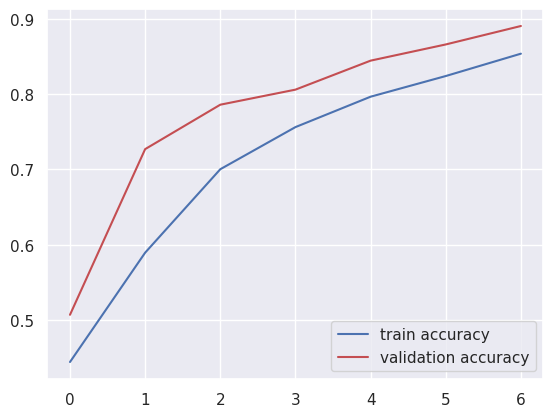

In [32]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [33]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

63/63 [==============================] - 58s 886ms/step
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       721
           1       0.84      0.91      0.88       255
           2       0.68      0.79      0.73       136
           3       0.93      0.90      0.92       601
           4       0.78      0.88      0.82       198
           5       0.80      0.60      0.68        89

    accuracy                           0.88      2000
   macro avg       0.83      0.83      0.82      2000
weighted avg       0.88      0.88      0.88      2000

